In [2]:
# prompt: import drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/capstone/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/capstone/dataset/val/strawberies/strawberies_084.jpg
/content/drive/MyDrive/capstone/dataset/val/strawberies/strawberies_073.jpg
/content/drive/MyDrive/capstone/dataset/val/strawberies/strawberies_075.jpg
/content/drive/MyDrive/capstone/dataset/val/strawberies/strawberies_074.jpg
/content/drive/MyDrive/capstone/dataset/val/strawberies/strawberies_031.jpg
/content/drive/MyDrive/capstone/dataset/val/strawberies/strawberies_02.jpg
/content/drive/MyDrive/capstone/dataset/val/strawberies/strawberies_04.jpg
/content/drive/MyDrive/capstone/dataset/val/strawberies/strawberies_060.jpg
/content/drive/MyDrive/capstone/dataset/val/strawberies/strawberies_05.jpg
/content/drive/MyDrive/capstone/dataset/val/strawberies/strawberies_099.jpg
/content/drive/MyDrive/capstone/dataset/val/spinach/spinach_011.jpg
/content/drive/MyDrive/capstone/dataset/val/spinach/spinach_061.JPG
/content/drive/MyDrive/capstone/dataset/val/spinach/spinach_039.jpg
/content/drive/MyDrive/capstone/dataset

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(tf.__version__)

2.17.1


In [5]:
# Create a list with the filepaths for training and testing
train_dir = Path('../content/drive/MyDrive/capstone/dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [6]:
val_dir = Path('../content/drive/MyDrive/capstone/dataset/val')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [7]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [8]:
train_df = image_processing(train_filepaths)
val_df = image_processing(val_filepaths)

In [9]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3420

Number of different labels: 41

Labels: ['sweetpotato' 'beetroot' 'soy beans' 'corn' 'garlic' 'lemon' 'lettuce'
 'onion' 'banana' 'spinach' 'mango' 'melon' 'grapes' 'carrot' 'tomato'
 'peas' 'guava' 'cucumber' 'mangosteen' 'orange' 'salak' 'cabbage'
 'cauliflower' 'raddish' 'watermelon' 'strawberies' 'pear' 'langsat'
 'turnip' 'papaya' 'avocado' 'potato' 'apple' 'eggplant' 'water-guava'
 'paprika' 'chilli pepper' 'kiwi' 'ginger' 'pineapple' 'durian']


In [10]:
train_df.head(5)

,Filepath,Label
0,../content/drive/MyDrive/capstone/dataset/trai...,sweetpotato
1,../content/drive/MyDrive/capstone/dataset/trai...,beetroot
2,../content/drive/MyDrive/capstone/dataset/trai...,soy beans
3,../content/drive/MyDrive/capstone/dataset/trai...,corn
4,../content/drive/MyDrive/capstone/dataset/trai...,garlic


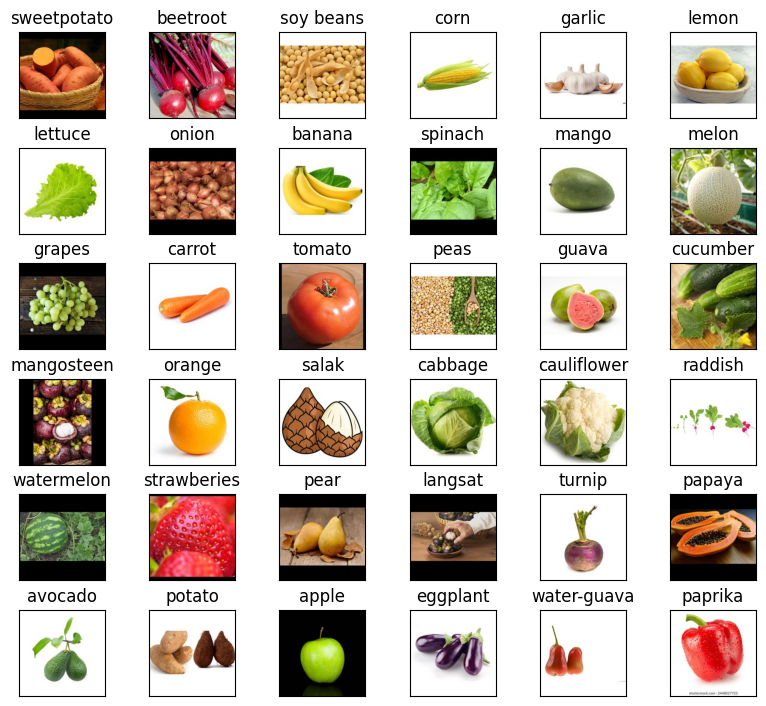

In [11]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

In [12]:
# Define ImageDataGenerators for train and validation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [13]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=0
)

Found 3420 validated image filenames belonging to 41 classes.


In [14]:
val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=False,
    seed=0
)

Found 367 validated image filenames belonging to 41 classes.


In [15]:
# Load pretrained MobileNetV2
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(41, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Corrected the loss function name
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 1059s 31s/step - accuracy: 0.0789 - loss: 3.6031 - val_accuracy: 0.4905 - val_loss: 2.3880
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 236s 8s/step - accuracy: 0.3719 - loss: 2.3881 - val_accuracy: 0.6894 - val_loss: 1.2332
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 240s 8s/step - accuracy: 0.5451 - loss: 1.5959 - val_accuracy: 0.7684 - val_loss: 0.8221
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 242s 8s/step - accuracy: 0.6476 - loss: 1.2064 - val_accuracy: 0.8093 - val_loss: 0.6517
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 242s 8s/step - accuracy: 0.7042 - loss: 0.9789 - val_accuracy: 0.8311 - val_loss: 0.5736
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 260s 9s/step - accuracy: 0.7275 - loss: 0.9136 - val_accuracy: 0.8474 - val_loss: 0.5152
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 283s 9s/step - accuracy: 0.7501 - loss: 0.8323 - val_accuracy: 0.8583 - val_loss: 0.4630
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.7844 - loss: 0.6881 - val_accuracy: 0.8583 - val_loss: 

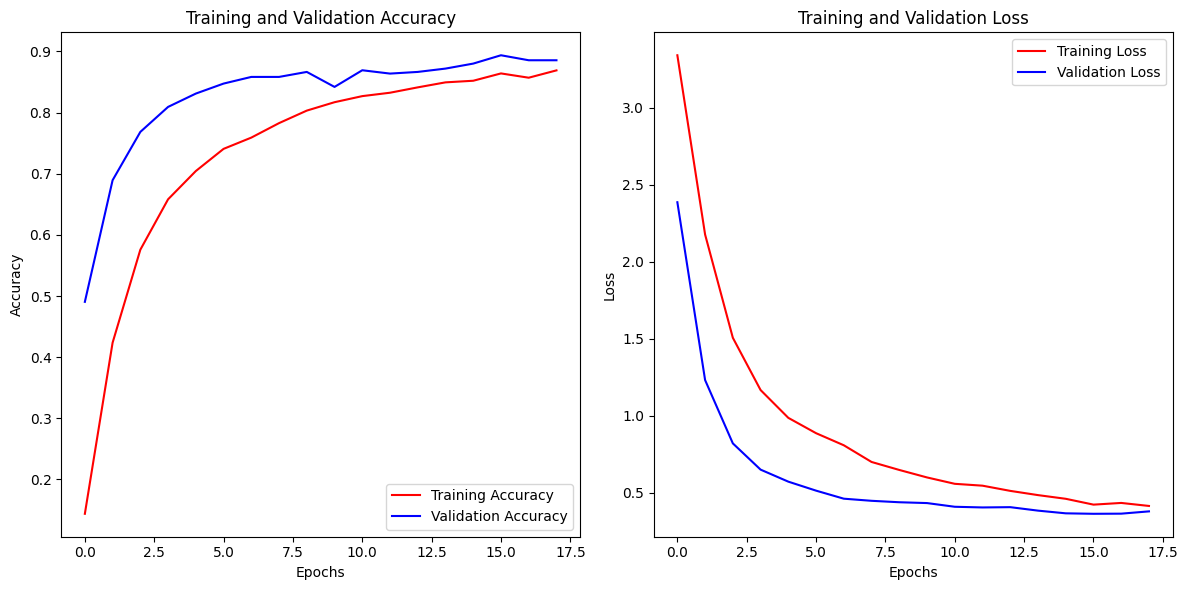

In [18]:
# Data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Membuat subplot
plt.figure(figsize=(12, 6))  # Atur ukuran figure

# Plot accuracy
plt.subplot(1, 2, 1)  # Baris 1, kolom 2, grafik ke-1
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)  # Baris 1, kolom 2, grafik ke-2
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Menampilkan grafik
plt.tight_layout()  # Memberi jarak antar subplot agar tidak tumpang tindih
plt.show()


In [22]:
# Predict the label of the test_images
pred = model.predict(val_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step


['mangosteen',
 'garlic',
 'grapes',
 'cauliflower',
 'eggplant',
 'soy beans',
 'lettuce',
 'water-guava',
 'water-guava',
 'avocado',
 'spinach',
 'carrot',
 'eggplant',
 'carrot',
 'strawberies',
 'orange',
 'ginger',
 'cauliflower',
 'mangosteen',
 'salak',
 'avocado',
 'lemon',
 'banana',
 'water-guava',
 'durian',
 'melon',
 'water-guava',
 'avocado',
 'chilli pepper',
 'mangosteen',
 'papaya',
 'raddish',
 'water-guava',
 'eggplant',
 'chilli pepper',
 'potato',
 'guava',
 'sweetpotato',
 'corn',
 'avocado',
 'banana',
 'eggplant',
 'watermelon',
 'pineapple',
 'pineapple',
 'banana',
 'cabbage',
 'chilli pepper',
 'onion',
 'durian',
 'spinach',
 'cabbage',
 'papaya',
 'soy beans',
 'eggplant',
 'langsat',
 'paprika',
 'peas',
 'cucumber',
 'onion',
 'langsat',
 'kiwi',
 'spinach',
 'paprika',
 'sweetpotato',
 'onion',
 'turnip',
 'mango',
 'carrot',
 'orange',
 'paprika',
 'guava',
 'chilli pepper',
 'ginger',
 'durian',
 'strawberies',
 'mango',
 'onion',
 'salak',
 'soy bean

In [23]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [26]:
img = output('../content/drive/MyDrive/capstone/test/test/cabbage/Image_9.jpg')
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


'cabbage'

In [27]:
# prompt: save the model

model.save('/content/drive/MyDrive/capstone/model.h5')